# More on Nonlinear Models

## Inference in Sinusoid Models

In the last lab, we studied the following problem. Consider the following dataset simulated using the model: 
\begin{equation*}
    y_t = \beta_0 + \beta_1 \cos(2 \pi f t) + \beta_2 \sin( 2 \pi f t) + \epsilon_t,
\end{equation*}
for $t = 1, \dots, n$ with some fixed values of $f, \beta_0, \beta_1, \beta_2$ and $\sigma$. The goal of this problem is to estimate $f$ along with associated uncertainty quantification.  

Today we will start by addressing the problem of estimating the other parameters $\beta_0, \beta_1, \beta_2, \sigma$ also along with uncertainty quantification. 

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [46]:
f = 0.2035
#f = 1.8
n = 400
b0 = 0
b1 = 3
b2 = 5
sig = 10

rng = np.random.default_rng(seed = 42)
errorsamples = rng.normal(loc = 0, scale = sig, size = n)
t = np.arange(1, n + 1)

y = b0 * np.ones(n) + b1 * np.cos(2 * np.pi * f * t) + b2 * np.sin(2 * np.pi * f * t) + errorsamples

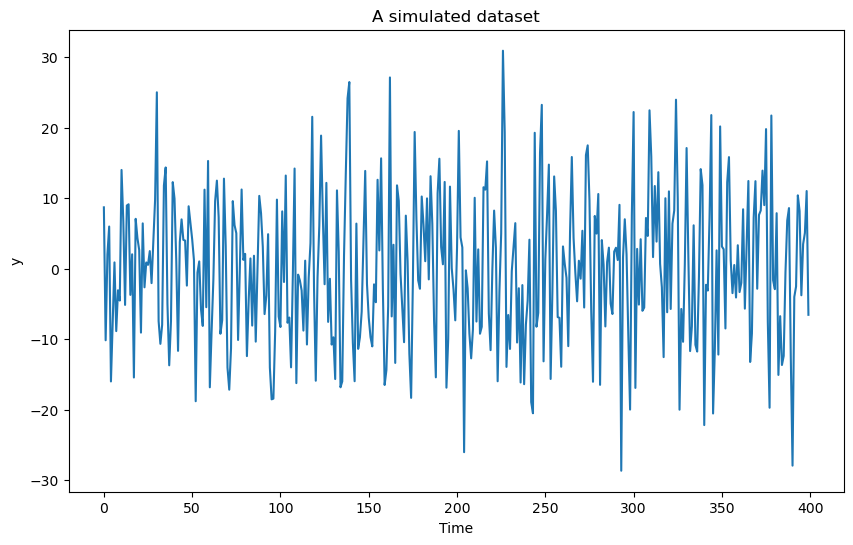

In [47]:
plt.figure(figsize = (10, 6))
plt.plot(y)
plt.xlabel('Time')
plt.ylabel('y')
plt.title('A simulated dataset')
plt.show()

To obtain the MLEs of the parameters, we first obtain the MLE of $f$ (as before), then plug in $f = \hat{f}$, and run linear regression to estimate the other parameters. 

In [48]:
def rss(f):
    x = np.arange(1, n + 1)
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([np.ones(n), xcos, xsin])

    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    
    return rss

0.2035520355203552


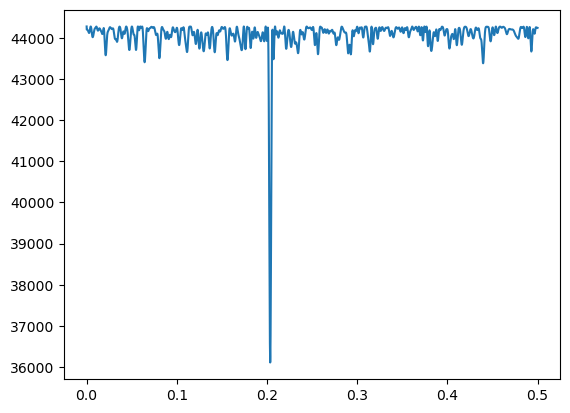

In [49]:
# We can minimize rss(f) over a fine grid of possible f values. 
# Since n is not very big here, we can work with a dense grid. 
ngrid = 100000
allfvals = np.linspace(0, 0.5, ngrid)
rssvals = np.array([rss(f) for f in allfvals])
fhat = allfvals[np.argmin(rssvals)]

print(fhat)

plt.plot(allfvals, rssvals)
plt.show()

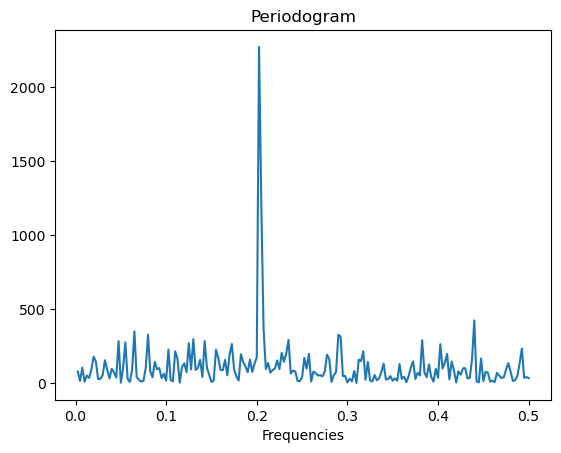

0.2025


In [50]:
# We can obtain an approximation to the MLE by working with Fourier frequencies and maximizing the periodogram. 
fft_y = np.fft.fft(y)
m = n // 2 - 1
fourier_freqs = np.arange(1/n, (1/2) + (1/n), 1/n)
m = len(fourier_freqs)
pgram_y = (np.abs(fft_y[1:(m + 1)]) ** 2)/n

plt.plot(fourier_freqs, pgram_y)
plt.xlabel("Frequencies")
plt.title("Periodogram")
plt.show()

fhat_fft = fourier_freqs[np.argmax(pgram_y)]
print(fhat_fft)

Except in rare cases where the true frequency is already a Fourier frequency, the MLE of $f$ computed on a fine grid will be closer to the truth compared to the MLE computed on the grid of Fourier frequencies. But the MLE computed on Fourier frequencies is much more computationally cheap. 

After computing the MLE of $f$, we can do linear regression (where $f$ is fixed the MLE) to compute the MLEs of the coefficient parameters and $\sigma$. 



In [51]:
x = np.arange(1, n + 1)
xcos = np.cos(2 * np.pi * fhat * x)
xsin = np.sin(2 * np.pi * fhat * x)
Xfhat = np.column_stack([np.ones(n), xcos, xsin])

md = sm.OLS(y, Xfhat).fit()
print(md.params) 
# this gives estimates of beta_0, beta_1, beta_2 (compare them to the true values which generated the data)

b0_est = md.params[0]
b1_est = md.params[1]
b2_est = md.params[2]
print(np.column_stack((np.array([b0_est, b1_est, b2_est]), np.array([b0, b1, b2]))))

rss_fhat = np.sum(md.resid ** 2)
sigma_mle = np.sqrt(rss_fhat / n)
sigma_unbiased = np.sqrt((rss_fhat)/(n - 3))
print(np.array([sigma_mle, sigma_unbiased, sig])) 
# sig is the true value of sigma which generated the data

[-0.05332889  3.00407151  5.63909328]
[[-0.05332889  0.        ]
 [ 3.00407151  3.        ]
 [ 5.63909328  5.        ]]
[ 9.50176964  9.53760297 10.        ]


Now let us use Bayesian inference for uncertainty quantification.  The Bayesian posterior for $f$ is:
\begin{equation*}
   I\{0 \leq f \leq 1/2\} \cdot |X_f^T X_f|^{-1/2} \cdot \left(\frac{1}{RSS(f)} \right)^{(n-p)/2}
\end{equation*}
where $p = 3$ and $|X_f^T X_f|$ denotes the determinant of $X_f^T X_f$. 

It is better to compute the logarithm of the posterior (as opposed to the posterior directly) because of numerical issues. 

In [52]:
def logpost(f):
    x = np.arange(1, n+1)
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([np.ones(n), xcos, xsin])
    p = X.shape[1]

    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    sgn, log_det = np.linalg.slogdet(np.dot(X.T, X)) 
    # sgn gives the sign of the determinant (in our case, this should 1)
    # log_det gives the logarithm of the absolute value of the determinant
    
    logval = ((p - n)/2) * np.log(rss) - 0.5 * log_det
    return logval

While evaluating the log posterior on a grid, it is important to make sure that we do not include frequencies $f$ for which $X_f^T X_f$ is singular. This will be the case for $f = 0$ and $f = 1/2$. When $f$ is very close to 0 or $0.5$, the term $|X_f^T X_f|^{-1/2}$ will be very large because of near-singularity of $X_f^T X_f$. We will therefore exclude frequencies very close to 0 and 0.5 from the grid while calculating posterior probabilities.  

From the Periodogram plotted above, it is clear that the maximizing frequency is around 0.2. So we will take a grid that around 0.2 (such as 0.05 to 0.35)

0.05 0.35


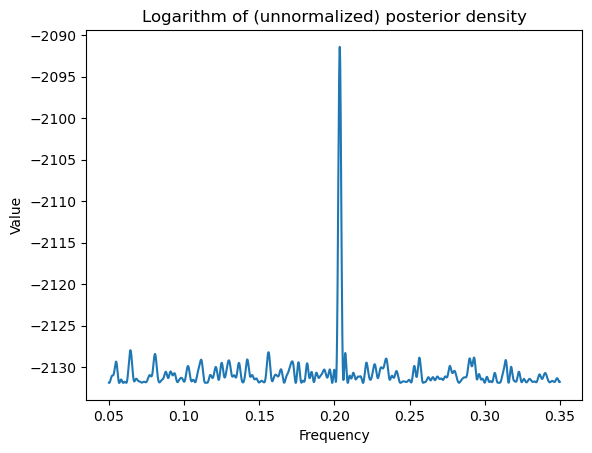

In [53]:
ngrid = 10000
allfvals = np.linspace(0.05, 0.35, ngrid)
print(np.min(allfvals), np.max(allfvals))

logpostvals = np.array([logpost(f) for f in allfvals])

plt.plot(allfvals, logpostvals)
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.title('Logarithm of (unnormalized) posterior density')
plt.show()

Note that the logarithm of the posterior looks similar to the periodogram. But the posterior itself will have only one peak (which dominates all other peaks).

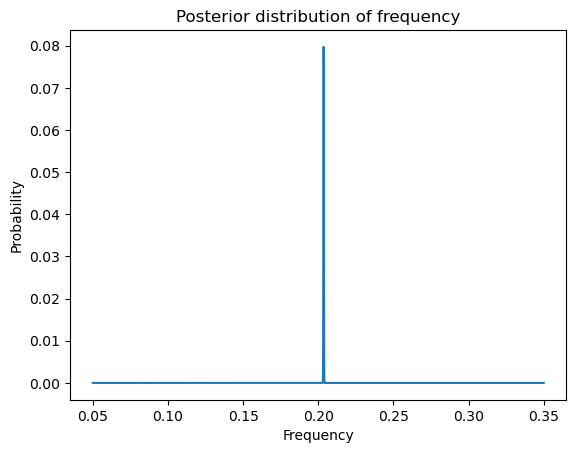

In [54]:
postvals_unnormalized = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals_unnormalized / (np.sum(postvals_unnormalized))

plt.plot(allfvals, postvals)
plt.xlabel('Frequency')
plt.ylabel('Probability')
plt.title('Posterior distribution of frequency')
plt.show()

We can draw posterior samples from f as follows. 

In [55]:
N = 2000
fpostsamples = rng.choice(allfvals, N, replace = True, p = postvals)

Given a posterior sample of $f$, a posterior sample of $\sigma$ can be drawn (this result was proved in Problem 4 of Homework one):
\begin{equation*}
   \frac{RSS(\hat{f})}{\sigma^2} \mid \text{data}, f \sim \chi^2_{n-3}
\end{equation*}
Further, given posterior samples from $f$ and $\sigma$, a posterior sample from $\beta = (\beta_0, \beta_1, \beta_2)$ is drawn using: 
\begin{equation*}
   \beta \mid \text{data}, \sigma, f \sim N_3 \left(\hat{\beta}, \sigma^2 (X_f^T X_f)^{-1} \right)
\end{equation*}
This is done in code as follows. 

In [56]:
post_samples = np.zeros(shape = (N, 5))
post_samples[:,0] = fpostsamples
for i in range(N):
    f = fpostsamples[i]
    x = np.arange(1, n + 1)
    xcos = np.cos(2 * np.pi * f * x)
    xsin = np.sin(2 * np.pi * f * x)
    X = np.column_stack([np.ones(n), xcos, xsin])
    p = X.shape[1]

    md_f = sm.OLS(y, X).fit()
    chirv = rng.chisquare(df = n - p)
    sig_sample = np.sqrt(np.sum(md_f.resid ** 2) / chirv) # posterior sample from sigma
    post_samples[i, (p + 1)] = sig_sample

    covmat = (sig_sample ** 2) * np.linalg.inv(np.dot(X.T, X))
    beta_sample = rng.multivariate_normal(mean = md_f.params, cov = covmat, size = 1)
    post_samples[i, 1:(p + 1)] = beta_sample

print(post_samples)

[[ 0.20340534 -0.56189444  3.28165364  5.35964685  9.18963362]
 [ 0.20367537 -1.22669044  3.16545782  6.3549404   9.63517389]
 [ 0.20343534 -0.18052831  3.81020787  5.08243908  9.38448971]
 ...
 [ 0.20355536 -0.24135565  2.17378505  5.44757671  9.50053706]
 [ 0.20355536 -0.37830076  2.90179999  6.50300091  9.49852951]
 [ 0.20337534 -0.52307159  4.11483084  4.68294379  9.84908592]]


Let us plot the posterior functions along with the original data to visualize uncertainty. 

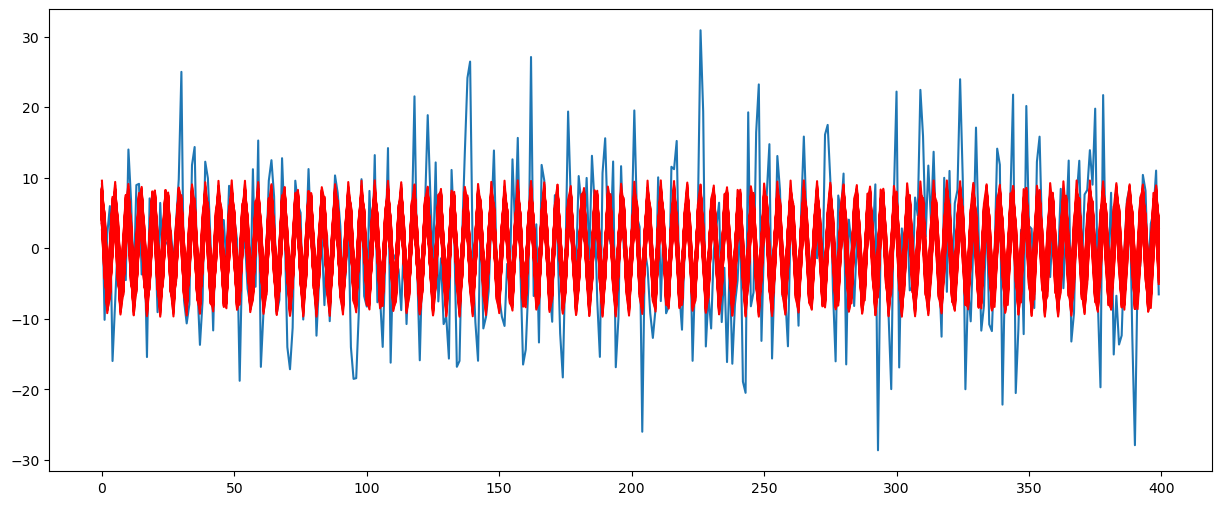

In [57]:
x = np.arange(1, n + 1)
plt.figure(figsize = (15, 6))
plt.plot(y)

for i in range(N):
    f = fpostsamples[i]
    b0 = post_samples[i, 1]
    b1 = post_samples[i, 2]
    b2 = post_samples[i, 3]

    ftdval = b0 + b1 * np.cos(2 * np.pi * f * x) + b2 * np.sin(2 * np.pi * f * x)
    plt.plot(ftdval, color = 'red')

A simple summary of the posterior samples can be obtained as follows. 

In [58]:
pd.DataFrame(post_samples).describe()
# note that the true value of f is 0.2035, b0 is 0, b1 is 3, b2 is 5 and sigma is 10

,0,1,2,3,4
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.203554,-0.048116,2.926668,5.487344,9.567343
std,0.000154,0.479084,1.240482,0.894120,0.337935
min,0.203045,-2.282401,-1.430247,1.670873,8.564508
25%,0.203435,-0.359168,2.134556,4.928442,9.343711
50%,0.203555,-0.061192,3.009265,5.519098,9.567323
75%,0.203645,0.268955,3.769393,6.097100,9.787657
max,0.204095,1.614744,6.128241,8.477974,10.710101


## Change-point Model

The same method can be used for inference in other nonlinear models. For example, consider the following model: 
\begin{equation*}
   y_t = \beta_0 + \beta_1 I\{t > c\} + \epsilon_t.
\end{equation*}
This is known as a change-point model. The parameter $c$ is called the change-point. $I\{t > c\}$ is the **indicator** function which takes the value 1 if $t > c$ and 0 otherwise. The function $\beta_0 + \beta_1 I\{t > c\}$ equals $\beta_0$ for times $t \leq c$ and equals $\beta_0 + \beta_1$ for times $t > c$. Therefore this model states that the level of the time series equals $\beta_0$ until a time $c$ at which point it switches to $\beta_0 + \beta_1$. The value of $c$ is therefore called the changepoint. From the given data $y_1, \dots, y_n$, we need to infer the parameter $c$ as well as $\beta_0, \beta_1, \sigma$. The unknown parameter $c$ makes it a nonlinear model. If $c$ were known, this will become a linear regression model with $X$-matrix given by
\begin{equation*}
    X_c = \begin{pmatrix} 1 & I\{1 > c\} \\ 1 & I\{2 > c\} \\ 1 & I\{3 > c\} \\ \cdot & \cdot \\ \cdot & \cdot \\ \cdot & \cdot \\ 1 & I\{n > c\} \end{pmatrix}
\end{equation*}

Inference for the parameter $c$ proceeds just like before. We first compute RSS($c$): 
\begin{equation*}
    RSS(c) := \min_{\beta_0, \beta_1} \sum_{t=1}^n (y_t - \beta_0 - \beta_1 I\{t > c\})^2
\end{equation*}
and then minimize over $c$ to obtain the MLE of $\hat{c}$. After finding $\hat{c}$, we can find the MLEs of the other parameters as in linear regression with known $c$. 

In [59]:
# Here is a simulated dataset having a change point:
n = 10000
mu1 = 0
mu2 = 0.4
dt = np.concatenate([np.repeat(mu1, n / 2), np.repeat(mu2, n / 2)])

sig = 1
errorsamples = rng.normal(loc = 0, scale = sig, size = n)

y = dt + errorsamples

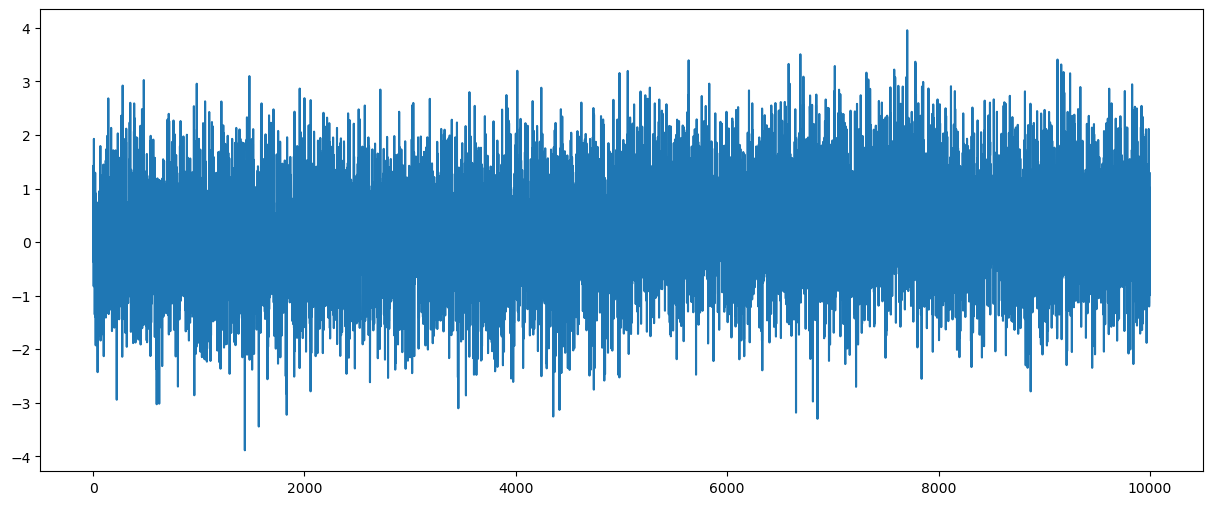

In [60]:
plt.figure(figsize = (15, 6))
plt.plot(y)
plt.show()

In [61]:
def rss(c):
    x = np.arange(1, n + 1)
    xc = (x > c).astype(float)
    X = np.column_stack([np.ones(n), xc])

    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)

    return rss

In [ ]:
allcvals = np.arange(5, n - 4) 
# we are ignoring a few points at the beginning and at the end
rssvals = np.array([rss(c) for c in allcvals])

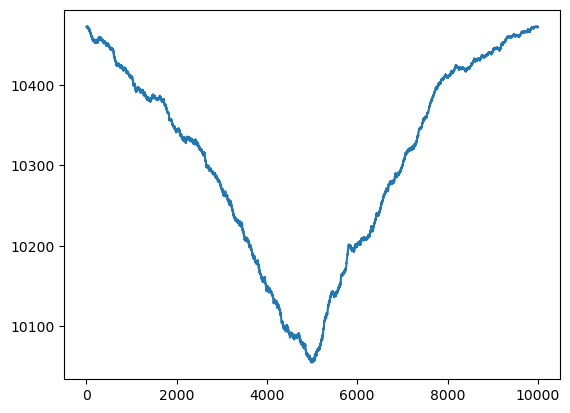

In [63]:
plt.plot(allcvals, rssvals)
plt.show()

In [64]:
c_hat = allcvals[np.argmin(rssvals)]
print(c_hat)

4981


In [ ]:
# Estimates of other parameters: 
x = np.arange(1, n + 1)
xc = (x > c_hat).astype(float)
X = np.column_stack([np.ones(n), xc])

md = sm.OLS(y, X).fit()
print(md.params) 
# this gives estimates of beta_0, beta_1 (compare them to the true values which generated the data)

b0_est = md.params[0]
b1_est = md.params[1]

b0_true = mu1
b1_true = mu2 - mu1
print(np.column_stack((np.array([b0_est, b1_est]), np.array([b0_true, b1_true]))))

rss_chat = np.sum(md.resid ** 2)
sigma_mle = np.sqrt(rss_chat / n)
sigma_unbiased = np.sqrt((rss_chat)/(n - 2))
print(np.array([sigma_mle, sigma_unbiased, sig])) 
#sig is the true value of sigma which generated the data

[0.01969268 0.40873694]
[[0.01969268 0.        ]
 [0.40873694 0.4       ]]
[1.00274789 1.00284818 1.        ]


Bayesian uncertainty quantification also works exactly as before.  The Bayesian posterior for $c$ is:
\begin{equation*}
 |X_c^T X_c|^{-1/2} \cdot \left(\frac{1}{RSS(c)} \right)^{(n-p)/2}
\end{equation*}
where $p = 2$ and $|X_c^T X_c|$ denotes the determinant of $X_c^T X_c$. 

As before, it is better to compute the logarithm of the posterior (as opposed to the posterior directly) because of numerical issues. 

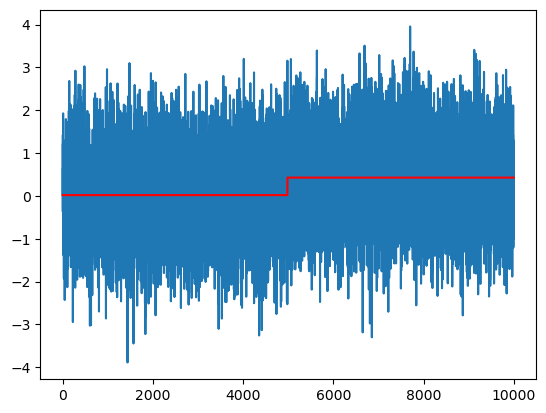

In [70]:
# Plot the fitted values:
plt.plot(y)
plt.plot(md.fittedvalues, color = 'red')

In [71]:
def logpost(c):
    x = np.arange(1, n+1)
    xc = (x > c).astype(float)
    X = np.column_stack([np.ones(n), xc])
    p = X.shape[1]

    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    sgn, log_det = np.linalg.slogdet(np.dot(X.T, X)) 
    # sgn gives the sign of the determinant (in our case, this should 1)
    # log_det gives the logarithm of the absolute value of the determinant
    
    logval = ((p - n) / 2) * np.log(rss) - 0.5 * log_det
    return logval

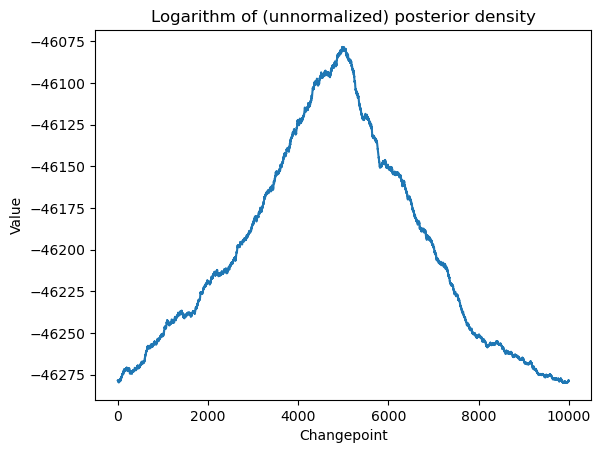

In [72]:
allcvals = np.arange(5, n - 4)
logpostvals = np.array([logpost(c) for c in allcvals])

plt.plot(allcvals, logpostvals)
plt.xlabel('Changepoint')
plt.ylabel('Value')
plt.title('Logarithm of (unnormalized) posterior density')
plt.show() 
# this plot looks similar to the RSS plot

Let us exponentiate the log-posterior values to get the posterior. 

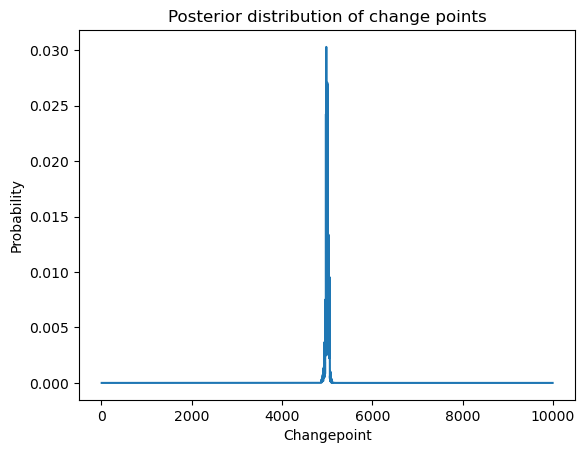

In [73]:
postvals_unnormalized = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals_unnormalized / (np.sum(postvals_unnormalized))

plt.plot(allcvals, postvals)
plt.xlabel('Changepoint')
plt.ylabel('Probability')
plt.title('Posterior distribution of change points')
plt.show()

We draw posterior samples exactly as before.

In [ ]:
N = 1000
cpostsamples = rng.choice(allcvals, N, replace = True, p = postvals)

post_samples = np.zeros(shape = (N, 4))
post_samples[:, 0] = cpostsamples
for i in range(N):
    c = cpostsamples[i]
    x = np.arange(1, n + 1)
    xc = (x > c).astype(float)
    X = np.column_stack([np.ones(n), xc])
    p = X.shape[1]

    md_c = sm.OLS(y, X).fit()

    chirv = rng.chisquare(df = n - p)
    sig_sample = np.sqrt(np.sum(md_c.resid ** 2) / chirv) # posterior sample from sigma
    post_samples[i, (p + 1)] = sig_sample

    covmat = (sig_sample ** 2) * np.linalg.inv(np.dot(X.T, X))
    beta_sample = rng.multivariate_normal(mean = md_c.params, cov = covmat, size = 1)
    post_samples[i, 1:(p + 1)] = beta_sample

print(post_samples)

[[5.01400000e+03 1.61186008e-02 4.15836357e-01 9.94694854e-01]
 [5.07500000e+03 2.21172885e-02 4.02259427e-01 9.96874208e-01]
 [4.93100000e+03 6.69816740e-03 4.29948362e-01 9.91129525e-01]
 ...
 [5.03000000e+03 1.52941625e-02 4.27556266e-01 1.00020949e+00]
 [5.01400000e+03 2.52471690e-02 3.94416060e-01 9.92312337e-01]
 [4.99600000e+03 1.99135692e-02 3.90096091e-01 1.00377472e+00]]


These posterior samples can be used to visualize the uncertainty in the fitted functions. 

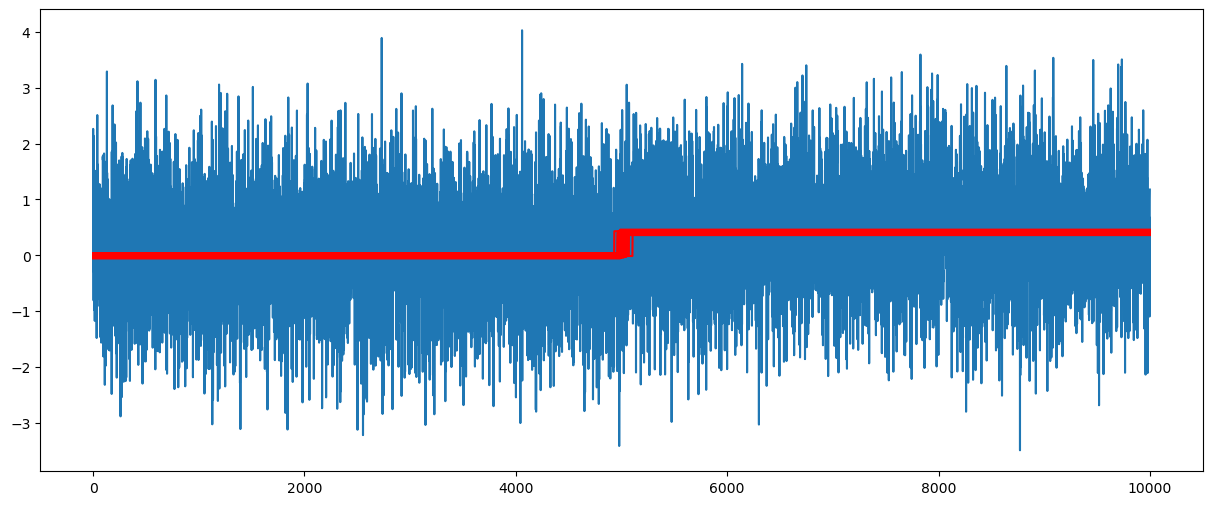

In [ ]:
x = np.arange(1, n + 1)
plt.figure(figsize = (15, 6))
plt.plot(y)

for i in range(N):
    c = cpostsamples[i]
    b0 = post_samples[i, 1]
    b1 = post_samples[i, 2]
    ftdval = b0 + b1 * (x > c).astype(float)

    plt.plot(ftdval, color = 'red')

In [ ]:
# Summary of the posterior samples:
pd.DataFrame(post_samples).describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,4990.655000,-0.007485,0.413230,1.002923
std,10.042451,0.014443,0.020551,0.007168
min,4931.000000,-0.053492,0.353096,0.978639
25%,4986.000000,-0.017177,0.399384,0.998240
50%,4989.000000,-0.007820,0.413441,1.002838
75%,4993.000000,0.002567,0.425842,1.007765
max,5104.000000,0.038280,0.483661,1.027721


## Change of Slope (or Broken Stick Regression)

Now consider the model: 
\begin{equation*}
  y_t = \beta_0 + \beta_1 t + \beta_2 (t - c)_+ + \epsilon_t
\end{equation*}
Here $(t - c)_+ = \max(t-c, 0)$ denotes the positive part function (also known as the ReLU function). This model has parameters $\beta_, \beta_1, \beta_2$ **and** $c$ (as well as $\sigma$). This is a nonlinear regression model because of the presence of the parameter $c$. If a known value is plugged in for $c$, we would revert to a linear regression model. 

This model states that, until the time point $c$, the slope parameter equals $\beta_1$. After $c$, the slope parameter becomes $\beta_1 + \beta_2$. 

Let us fit this model to the US population dataset that we previously used in the class. 

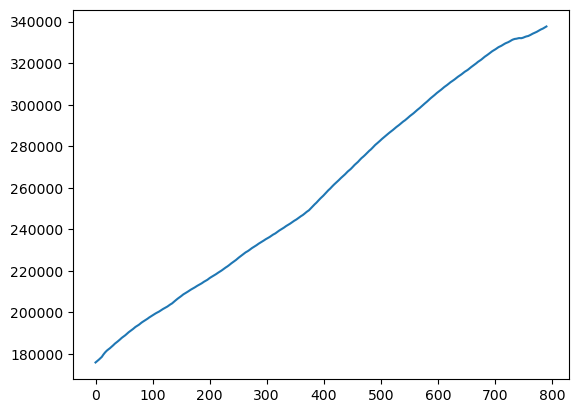

In [ ]:
uspop = pd.read_csv("POPTHM-Jan2025FRED.csv")
y = uspop['POPTHM']
n = len(y)

plt.plot(y)
plt.show()

For obtaining the MLEs, we proceed exactly as before. The RSS is now given by: 
\begin{equation*}
    RSS(c) = \min_{\beta_0, \beta_1, \beta_2} \sum_{t=1}^n \left(y_t - \beta_0 - \beta_1 t - \beta_2 (t - c)_+ \right)^2
\end{equation*}

In [ ]:
def rss(c):
    x = np.arange(1, n + 1)
    xc = ((x > c).astype(float)) * (x - c)
    X = np.column_stack([np.ones(n), x, xc])

    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)

    return rss

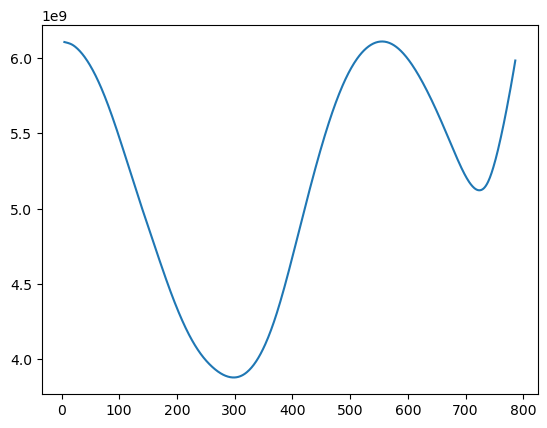

In [ ]:
allcvals = np.arange(5, n - 4) # we are ignoring a few points at the beginning and at the end
rssvals = np.array([rss(c) for c in allcvals])

plt.plot(allcvals, rssvals)
plt.show()

In [ ]:
c_hat = allcvals[np.argmin(rssvals)]
print(c_hat)

298


In [ ]:
# Estimates of other parameters: 
x = np.arange(1, n + 1)
c = c_hat
xc = ((x > c).astype(float)) * (x - c)
X = np.column_stack([np.ones(n), x, xc])

md = sm.OLS(y, X).fit()
print(md.params) 
# this gives estimates of beta_0, beta_1, beta_2 (this is a real dataset so there are no true parameters)

rss_chat = np.sum(md.resid ** 2)
sigma_mle = np.sqrt(rss_chat / n)
sigma_unbiased = np.sqrt((rss_chat) / (n - 3))
print(np.array([sigma_mle, sigma_unbiased])) 
# sig is the true value of sigma which generated the data

const    178331.892380
x1          191.173841
x2           32.346330
dtype: float64
[2214.41969096 2218.63095249]


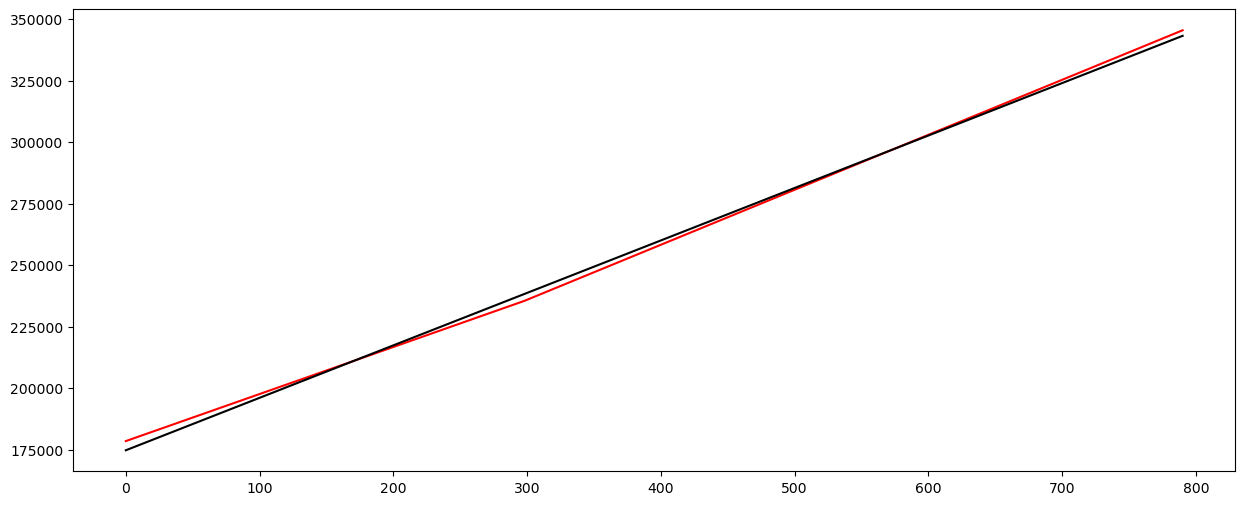

In [ ]:
# Plot fitted values
X_linmod = np.column_stack([np.ones(n), x])
linmod = sm.OLS(y, X_linmod).fit()

plt.figure(figsize = (15, 6))
# Plot this broken regression fitted values along with linear model fitted values 
plt.plot(y, color = 'None')
plt.plot(md.fittedvalues, color = 'red')
plt.plot(linmod.fittedvalues, color = 'black')
plt.show()

In [ ]:
# Bayesian log posterior
def logpost(c):
    x = np.arange(1, n + 1)
    xc = ((x > c).astype(float)) * (x - c)
    X = np.column_stack([np.ones(n), x, xc])
    p = X.shape[1]

    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    sgn, log_det = np.linalg.slogdet(np.dot(X.T, X)) #sgn gives the sign of the determinant (in our case, this should 1)
    # log_det gives the logarithm of the absolute value of the determinant
    
    logval = ((p - n) / 2) * np.log(rss) - 0.5 * log_det
    return logval

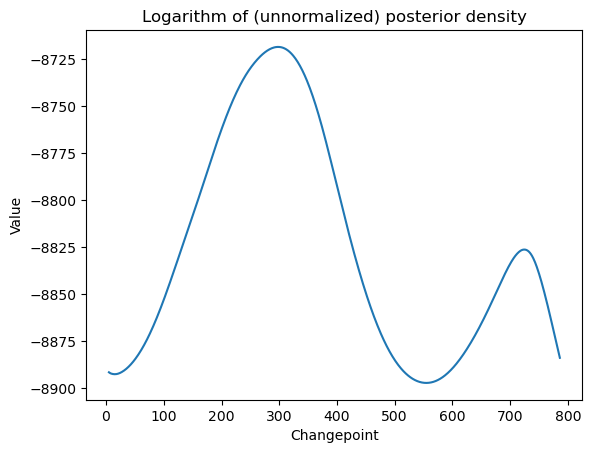

In [ ]:
allcvals = np.arange(5, n - 4)
logpostvals = np.array([logpost(c) for c in allcvals])

plt.plot(allcvals, logpostvals)
plt.xlabel('Changepoint')
plt.ylabel('Value')
plt.title('Logarithm of (unnormalized) posterior density')
plt.show() 
# this plot looks similar to the RSS plot

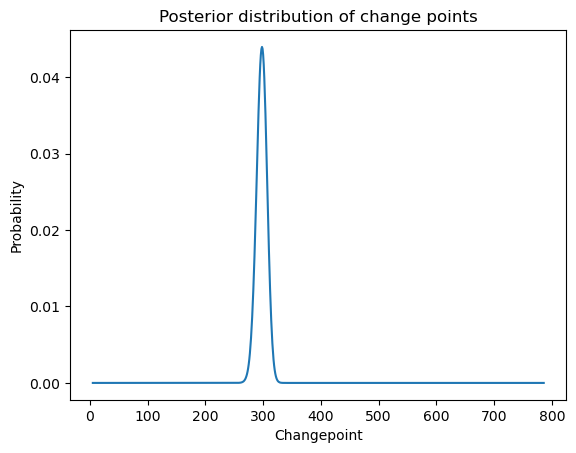

In [ ]:
postvals_unnormalized = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals_unnormalized / (np.sum(postvals_unnormalized))

plt.plot(allcvals, postvals)
plt.xlabel('Changepoint')
plt.ylabel('Probability')
plt.title('Posterior distribution of change points')
plt.show()

In [ ]:
# Drawing posterior samples: 
N = 2000
cpostsamples = rng.choice(allcvals, N, replace = True, p = postvals)

post_samples = np.zeros(shape = (N, 5))
post_samples[:, 0] = cpostsamples
for i in range(N):
    f = cpostsamples[i]
    x = np.arange(1, n + 1)
    xc = ((x > c).astype(float)) * (x - c)
    X = np.column_stack([np.ones(n), x, xc])
    p = X.shape[1]

    md_c = sm.OLS(y, X).fit()
    chirv = rng.chisquare(df = n - p)
    sig_sample = np.sqrt(np.sum(md_c.resid ** 2) / chirv) # posterior sample from sigma
    post_samples[i, (p + 1)] = sig_sample

    covmat = (sig_sample ** 2) * np.linalg.inv(np.dot(X.T, X))
    beta_sample = rng.multivariate_normal(mean = md_c.params, cov = covmat, size = 1)
    post_samples[i, 1:(p + 1)] = beta_sample

print(post_samples)

[[3.02000000e+02 1.78679868e+05 1.89836033e+02 3.42169717e+01
  2.22133894e+03]
 [2.85000000e+02 1.78325271e+05 1.91295418e+02 3.24809108e+01
  2.25595672e+03]
 [2.83000000e+02 1.78395919e+05 1.90801617e+02 3.30139821e+01
  2.25832125e+03]
 ...
 [2.90000000e+02 1.78563273e+05 1.90179251e+02 3.33837727e+01
  2.15566567e+03]
 [2.90000000e+02 1.78292844e+05 1.91629020e+02 3.21929322e+01
  2.29143430e+03]
 [3.04000000e+02 1.78581825e+05 1.90525611e+02 3.27431913e+01
  2.21071767e+03]]


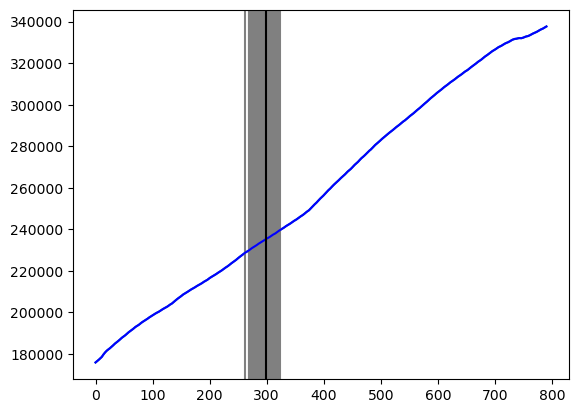

In [ ]:
# Let us plot the posterior samples for c on the original plot: 
plt.plot(y)

for i in range(N):
    plt.axvline(x = cpostsamples[i], color = 'gray')

plt.plot(y, color = 'blue')
plt.axvline(x = c_hat, color = 'black')
plt.show()

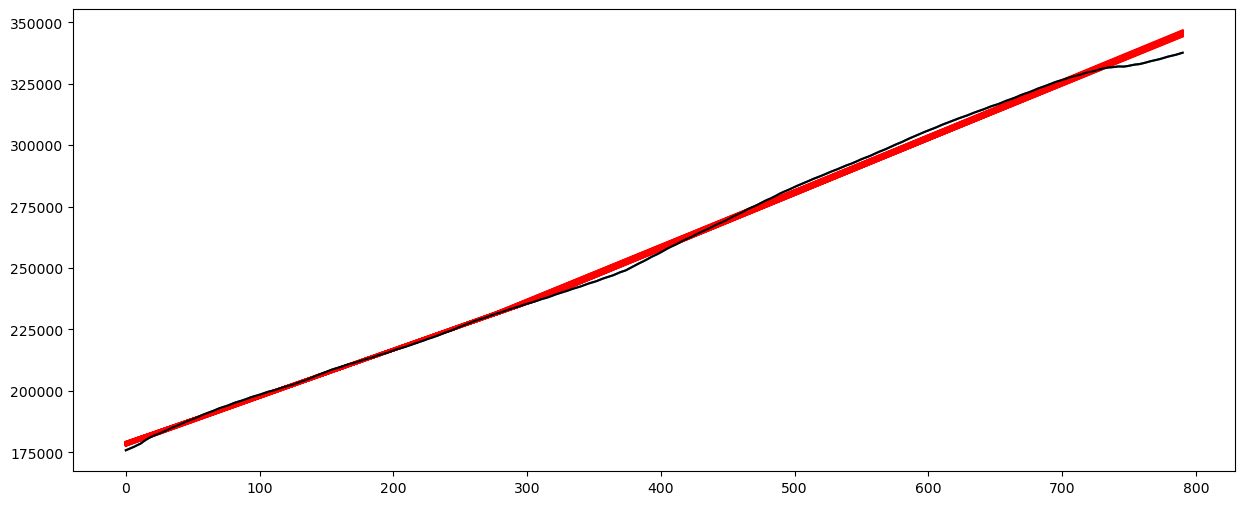

In [ ]:
# Plot the fitted values for the different posterior draws:
x = np.arange(1, n + 1)
plt.figure(figsize = (15, 6))
plt.plot(y)

for i in range(N):
    c = cpostsamples[i]
    b0 = post_samples[i, 1]
    b1 = post_samples[i, 2]
    b2 = post_samples[i, 3]

    ftdval = b0 + b1 * x + b2 * ((x > c).astype(float)) * (x - c)

    plt.plot(ftdval, color = 'red')
plt.plot(y, color = 'black')
plt.show()

In [ ]:
#Summary of the posterior samples:
pd.DataFrame(post_samples).describe()

,0,1,2,3,4
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,297.426500,178341.563897,191.135089,32.379440,2221.533224
std,9.176748,236.325641,1.082882,1.523587,56.259513
min,262.000000,177418.875703,187.952460,27.840629,2029.175952
25%,291.000000,178179.981065,190.371263,31.358716,2182.856960
50%,297.000000,178349.875769,191.128412,32.388153,2219.748677
75%,304.000000,178505.520157,191.874330,33.446580,2260.256411
max,323.000000,179087.623121,194.646661,37.195418,2429.107218
